In [1]:
classes = ['down', 'left', 'right', 'stop', 'up']

In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import librosa
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Define the dataset class
class My_Dataset(Dataset):
    def __init__(self, csv_file, root_dir, set_number, sample_rate=16000, n_mfcc=13, n_mels=128):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.set_number = set_number
        self.sample_rate = sample_rate
        self.n_mfcc = n_mfcc
        self.n_mels = n_mels
        self.filtered_indices = self.filter()

    def __len__(self):
        return len(self.filtered_indices)

    def filter(self):
        return [idx for idx in range(len(self.data)) if int(self.data.iloc[idx, 1]) == self.set_number]

    def __getitem__(self, idx):
        idx = self.filtered_indices[idx]
        file = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        class_label = int(self.data.iloc[idx, 2]) 
        try:
            waveform, _ = librosa.load(file, sr=self.sample_rate)
            spectrogram = librosa.feature.melspectrogram(y=waveform, sr=16000, n_mels=128, hop_length=128, n_fft=2048)
            spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
            spectrogram = np.expand_dims(spectrogram, axis=0)  # Add channel dimension
            return torch.tensor(spectrogram, dtype=torch.float32), torch.tensor(class_label, dtype=torch.long)
        except Exception as e:
            print(f"Error loading {file}: {e}")
            return self.__getitem__((idx + 1) % len(self.filtered_indices))  # Load next sample

# Load the datasets
csv_file = 'dataset_2.csv'
root_dir = 'dataset'
train_dataset = My_Dataset(csv_file, root_dir, 0)
test_dataset = My_Dataset(csv_file, root_dir, 1)
valid_dataset = My_Dataset(csv_file, root_dir, 2)

In [10]:
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader
# from torchvision import datasets
from torchvision.transforms import ToTensor
plt.style.use('ggplot')

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

for batch, (X, y) in enumerate(train_loader):

    print(X.shape, y.shape)
    if batch == 3:
        break

#dimensiuni: cat mai patrat - 128x128
    

torch.Size([64, 1, 128, 126]) torch.Size([64])
torch.Size([64, 1, 128, 126]) torch.Size([64])
torch.Size([64, 1, 128, 126]) torch.Size([64])
torch.Size([64, 1, 128, 126]) torch.Size([64])


In [12]:

# Define the model
class ModifiedResNet(nn.Module):
    def __init__(self, base_model, num_classes=5):
        super(ModifiedResNet, self).__init__()
        self.base_model = base_model
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)
        self.dropout = nn.Dropout(p=0.5)  # Add dropout for regularization

    def forward(self, x):
        x = self.base_model.conv1(x)
        x = self.base_model.bn1(x)
        x = self.base_model.relu(x)
        x = self.base_model.maxpool(x)
        x = self.base_model.layer1(x)
        x = self.base_model.layer2(x)
        x = self.base_model.layer3(x)
        x = self.base_model.layer4(x)
        x = self.base_model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)  # Apply dropout before the final layer
        x = self.base_model.fc(x)
        return x

def get_resnet(version=18, freeze=False, num_classes=5, device='cpu', pretrained=True):
    weights = None if not pretrained else models.ResNet18_Weights.IMAGENET1K_V1
    resnet = models.__dict__[f'resnet{version}'](weights=weights)
    if freeze:
        for param in resnet.parameters():
            param.requires_grad = False
    model = ModifiedResNet(resnet, num_classes)
    return model.to(device)

In [13]:
model = get_resnet(version=18, num_classes=5, device=device)
# model.conv1 = torch.nn.Conv2d(64, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
print(model)
optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

ModifiedResNet(
  (base_model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [14]:

# Training function
def train(model, device, train_loader, optimizer, epoch, log_interval, scheduler):
    model.train()
    running_loss = 0.0
    correct = 0
    train_losses = []
    train_accuracies = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        # data =data.repeat(1, 3, 1, 1)
        # data = data.squeeze(1)  # Remove channel dimension
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    avg_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    scheduler.step()
    return avg_loss, accuracy

In [15]:
def number_of_correct(pred, target):
    return pred.squeeze().eq(target).sum().item()

def get_likely_index(tensor):
    return tensor.argmax(dim=-1)

all_preds = []
all_targets = []
# Testing function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    test_losses = []
    test_accuracies = []
   
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # data = data.repeat(1, 3, 1, 1)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)  # Accumulate the loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader.dataset)  # Calculate average loss
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(avg_test_loss)
    test_accuracies.append(accuracy)
    print(f'\nTest set: Average loss: {avg_test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')
    return avg_test_loss, accuracy, all_preds, all_targets


In [16]:
n_epoch = 5
log_interval = 20

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

with tqdm(total=n_epoch) as pbar:
    train_epoch_losses = []
    train_epoch_accuracies = []
    test_epoch_losses = []
    test_epoch_accuracies = []
    all_preds = []
    all_targets = []
    for epoch in range(1, n_epoch + 1):
        loss, acc = train(model, device, train_loader, optimizer, epoch, log_interval, scheduler)
        train_epoch_losses.append(loss)
        train_epoch_accuracies.append(acc)

        loss, acc, preds, targets = test(model, device, test_loader)
        test_epoch_losses.append(loss)
        test_epoch_accuracies.append(acc)
        torch.save(model.state_dict(), 'resnet_gsc.pt')
        pbar.update(1)


  0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 1 [0/13363 (0%)]	Loss: 2.044619
Train Epoch: 1 [1280/13363 (10%)]	Loss: 0.448288
Train Epoch: 1 [2560/13363 (19%)]	Loss: 0.498996
Train Epoch: 1 [3840/13363 (29%)]	Loss: 0.116165
Train Epoch: 1 [5120/13363 (38%)]	Loss: 0.209032
Train Epoch: 1 [6400/13363 (48%)]	Loss: 0.111614
Train Epoch: 1 [7680/13363 (57%)]	Loss: 0.095715
Train Epoch: 1 [8960/13363 (67%)]	Loss: 0.087863
Train Epoch: 1 [10240/13363 (77%)]	Loss: 0.089675
Train Epoch: 1 [11520/13363 (86%)]	Loss: 0.086589
Train Epoch: 1 [12800/13363 (96%)]	Loss: 0.097928


 20%|██        | 1/5 [09:40<38:43, 580.78s/it]


Test set: Average loss: 0.2491, Accuracy: 3529/3818 (92%)

Train Epoch: 2 [0/13363 (0%)]	Loss: 0.073705
Train Epoch: 2 [1280/13363 (10%)]	Loss: 0.251471
Train Epoch: 2 [2560/13363 (19%)]	Loss: 0.022410
Train Epoch: 2 [3840/13363 (29%)]	Loss: 0.035890
Train Epoch: 2 [5120/13363 (38%)]	Loss: 0.231905
Train Epoch: 2 [6400/13363 (48%)]	Loss: 0.007008
Train Epoch: 2 [7680/13363 (57%)]	Loss: 0.039731
Train Epoch: 2 [8960/13363 (67%)]	Loss: 0.064824
Train Epoch: 2 [10240/13363 (77%)]	Loss: 0.061531
Train Epoch: 2 [11520/13363 (86%)]	Loss: 0.017102
Train Epoch: 2 [12800/13363 (96%)]	Loss: 0.184521


 40%|████      | 2/5 [19:35<29:27, 589.00s/it]


Test set: Average loss: 0.0818, Accuracy: 3707/3818 (97%)

Train Epoch: 3 [0/13363 (0%)]	Loss: 0.037099
Train Epoch: 3 [1280/13363 (10%)]	Loss: 0.025411
Train Epoch: 3 [2560/13363 (19%)]	Loss: 0.096062
Train Epoch: 3 [3840/13363 (29%)]	Loss: 0.029555
Train Epoch: 3 [5120/13363 (38%)]	Loss: 0.108285
Train Epoch: 3 [6400/13363 (48%)]	Loss: 0.152297
Train Epoch: 3 [7680/13363 (57%)]	Loss: 0.039610
Train Epoch: 3 [8960/13363 (67%)]	Loss: 0.074803
Train Epoch: 3 [10240/13363 (77%)]	Loss: 0.129825
Train Epoch: 3 [11520/13363 (86%)]	Loss: 0.006951
Train Epoch: 3 [12800/13363 (96%)]	Loss: 0.128078


 60%|██████    | 3/5 [29:56<20:07, 603.73s/it]


Test set: Average loss: 0.1587, Accuracy: 3610/3818 (95%)

Train Epoch: 4 [0/13363 (0%)]	Loss: 0.165482
Train Epoch: 4 [1280/13363 (10%)]	Loss: 0.184471
Train Epoch: 4 [2560/13363 (19%)]	Loss: 0.037249
Train Epoch: 4 [3840/13363 (29%)]	Loss: 0.052776
Train Epoch: 4 [5120/13363 (38%)]	Loss: 0.093626
Train Epoch: 4 [6400/13363 (48%)]	Loss: 0.066697
Train Epoch: 4 [7680/13363 (57%)]	Loss: 0.040374
Train Epoch: 4 [8960/13363 (67%)]	Loss: 0.153512
Train Epoch: 4 [10240/13363 (77%)]	Loss: 0.061751
Train Epoch: 4 [11520/13363 (86%)]	Loss: 0.060946
Train Epoch: 4 [12800/13363 (96%)]	Loss: 0.069690


 80%|████████  | 4/5 [39:43<09:57, 597.10s/it]


Test set: Average loss: 0.1383, Accuracy: 3649/3818 (96%)

Train Epoch: 5 [0/13363 (0%)]	Loss: 0.154541
Train Epoch: 5 [1280/13363 (10%)]	Loss: 0.006493
Train Epoch: 5 [2560/13363 (19%)]	Loss: 0.127602
Train Epoch: 5 [3840/13363 (29%)]	Loss: 0.008675
Train Epoch: 5 [5120/13363 (38%)]	Loss: 0.061795
Train Epoch: 5 [6400/13363 (48%)]	Loss: 0.006804
Train Epoch: 5 [7680/13363 (57%)]	Loss: 0.100647
Train Epoch: 5 [8960/13363 (67%)]	Loss: 0.119914
Train Epoch: 5 [10240/13363 (77%)]	Loss: 0.037536
Train Epoch: 5 [11520/13363 (86%)]	Loss: 0.075208
Train Epoch: 5 [12800/13363 (96%)]	Loss: 0.027535


100%|██████████| 5/5 [48:00<00:00, 576.12s/it]


Test set: Average loss: 0.0575, Accuracy: 3738/3818 (98%)



              precision    recall  f1-score   support

        stop       0.97      0.95      0.96      3885
          up       0.97      0.96      0.96      3580
        down       0.99      0.97      0.98      3910
        left       0.94      0.94      0.94      3955
       right       0.91      0.96      0.94      3760

    accuracy                           0.96     19090
   macro avg       0.96      0.96      0.96     19090
weighted avg       0.96      0.96      0.96     19090

[[3696   22    3  123   41]
 [  35 3420   21   15   89]
 [  16   60 3778    3   53]
 [  50    9    2 3731  163]
 [  20   10   10  112 3608]]


(<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x1fd6624a090>,
 None)

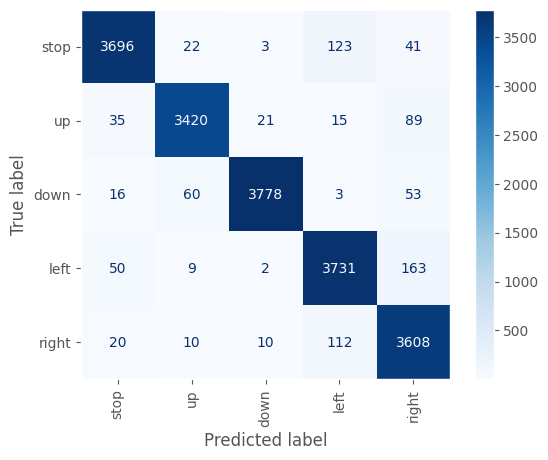

In [17]:
from sklearn.metrics import classification_report

report = classification_report(all_targets, all_preds, target_names=['stop', 'up', 'down', 'left', 'right'])  # Adjust target_names based on your dataset
print(report)
from sklearn.metrics import confusion_matrix

confision_matrix = confusion_matrix(all_targets, all_preds)
#print confusion matrix and labels
print(confision_matrix)


# confusion matrix display using sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming the confusion matrix is stored in the variable confusion_matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confision_matrix, display_labels=['stop', 'up', 'down', 'left', 'right'])

#rempove the grid lines from the confusion matrix 
disp.plot(cmap='Blues', values_format='d', xticks_rotation='vertical', ax=None), plt.grid(False)


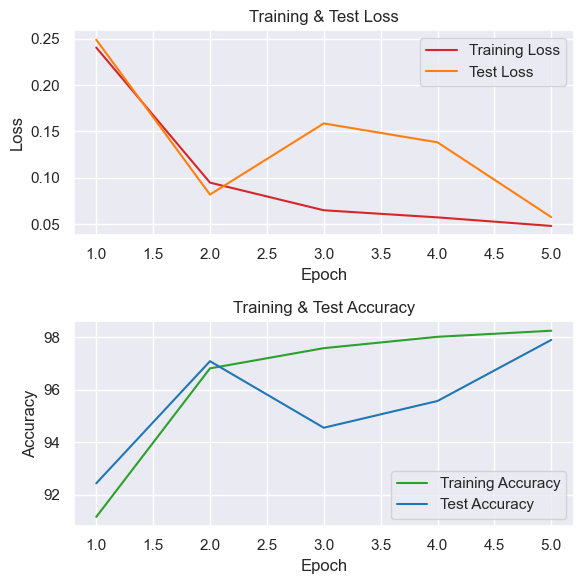

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Assuming the number of epochs is the length of the longest list
num_epochs = 100
epochs = range(1, num_epochs + 1)

# Create a figure with 2 subplots, vertically aligned, with a smaller size
fig, axs = plt.subplots(2, 1, figsize=(6, 6))

# Plot training loss and test loss in the same subplot
axs[0].plot(epochs[:len(train_epoch_losses)], train_epoch_losses, label='Training Loss', color='tab:red')
axs[0].plot(epochs[:len(test_epoch_losses)], test_epoch_losses, label='Test Loss', color='tab:orange')
axs[0].set_title('Training & Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot training accuracy and test accuracy in the same subplot
axs[1].plot(epochs[:len(train_epoch_accuracies)], train_epoch_accuracies, label='Training Accuracy', color='tab:green')
axs[1].plot(epochs[:len(test_epoch_accuracies)], test_epoch_accuracies, label='Test Accuracy', color='tab:blue')
axs[1].set_title('Training & Test Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()